In [11]:
import pandas as pd
import numpy as np
import scipy
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
def flat_corr(data, method):
    data = data.T.corr(method=method, min_periods=5)
    data = np.tril(data, k = -1).flatten()
    data = data[(data!=0) & (~np.isnan(data))]
    return data

def gen_corr_df(data, method, name):
    data = flat_corr(data, method=method)
    
    corr_df = pd.DataFrame(data, columns = ['Correlation'])
    if method == 'pearson': method_name = "Pearson's R"
    elif method == 'spearman': method_name = "Spearman's R"
    corr_df['Method'] = [method_name] * len(corr_df)
    corr_df['Viability'] = [name] * len(corr_df)
    
    return corr_df

# Compute and plot GDSC correlation

In [32]:
# PATH TO GDSC dataset downloaded from https://www.cancerrxgene.org/downloads/drug_data?screening_set=GDSC1
#gdsc_drug_response = pd.read_csv('YOUR PATH')
gdsc_drug_response = pd.read_csv('/Users/katja/Projects/ProstateCancer/databases/GDSC/PANCANCER_IC_Wed Dec  6 11_52_08 2023.csv')
# drug pathways, downloaded from the above link under Preview: drugs included in download (.csv)
#drug_pathways = pd.read_csv('YOUR PATH') 
drug_pathways = pd.read_csv('/Users/katja/Projects/ProstateCancer/databases/GDSC/drug_pathways.csv')

gdsc_drug_response['IC50/max con'] = gdsc_drug_response['IC50'] / gdsc_drug_response['Max Conc']
gdsc_drug_response['IC50 zscore'] = gdsc_drug_response['Z score']

gdsc_drug_response = gdsc_drug_response.merge(drug_pathways[['drug_id', 'pathway_name']], 
                                              how = 'left', left_on = 'Drug ID', right_on = 'drug_id')
gdsc_drug_response.head()

,Drug Name,Drug ID,Cell Line Name,Cosmic ID,TCGA Classification,Tissue,Tissue Sub-type,IC50,AUC,Max Conc,RMSE,Z score,Dataset Version,IC50/max con,IC50 zscore,drug_id,pathway_name
0,Erlotinib,1,ES5,684057,UNCLASSIFIED,bone,ewings_sarcoma,3.966813,0.985678,2.0,0.026081,1.299144,GDSC1,1.983406,1.299144,1,EGFR signaling
1,Erlotinib,1,ES7,684059,UNCLASSIFIED,bone,ewings_sarcoma,2.692090,0.972690,2.0,0.110059,0.156076,GDSC1,1.346045,0.156076,1,EGFR signaling
2,Erlotinib,1,EW-11,684062,UNCLASSIFIED,bone,ewings_sarcoma,2.477990,0.944459,2.0,0.087019,-0.035912,GDSC1,1.238995,-0.035912,1,EGFR signaling
3,Erlotinib,1,SK-ES-1,684072,UNCLASSIFIED,bone,ewings_sarcoma,2.033564,0.950758,2.0,0.016290,-0.434437,GDSC1,1.016782,-0.434437,1,EGFR signaling
4,Erlotinib,1,COLO-829,687448,SKCM,skin,melanoma,2.966007,0.954778,2.0,0.180255,0.401702,GDSC1,1.483003,0.401702,1,EGFR signaling


In [33]:
def pivot_column(colname, df):
    return gdsc_drug_response.pivot(index='Cosmic ID', values = colname, columns = 'Drug ID')

gdsc_IC50_df = pivot_column('IC50', gdsc_drug_response)
gdsc_IC50_df.head()

Drug ID,1,3,5,6,9,11,17,29,30,32,...,1495,1496,1497,1498,1502,1526,1527,1529,1530,1531
Cosmic ID,,,,,,,,,,,,,,,,,,,,,
683667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.010083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.349978,-0.666270,1.877431,1.712663,4.215675,1.963601,-0.435702,-2.037157,4.272344,4.502007
684057,3.966813,0.584990,3.773630,2.695236,0.930484,0.678819,5.694270,2.665616,3.437794,3.722149,...,2.349629,1.149465,1.671475,3.401612,4.512388,4.226023,-0.722279,-0.543282,4.786753,4.700326
684059,2.692090,-0.026774,2.990953,2.490269,0.550531,0.074408,4.997813,2.392512,3.286797,2.981823,...,0.591728,-1.223006,1.414403,3.071024,4.126828,3.303773,-1.424201,-2.345298,4.652260,4.521558
684062,2.477990,-2.123181,3.600300,2.774900,0.232037,0.918106,5.714389,1.087475,4.147816,3.890122,...,2.777843,-0.942229,-1.781947,3.449701,3.270090,3.738364,-1.140185,-0.523266,3.448501,3.118946


In [17]:
gdsc_pears_corr_df = gen_corr_df(pivot_column('IC50', gdsc_drug_response), 'pearson', 'IC50')
gdsc_spear_corr_df = gen_corr_df(pivot_column('IC50', gdsc_drug_response), 'spearman', 'IC50')
gdsc_pears_zscore_corr_df = gen_corr_df(pivot_column('IC50 zscore', gdsc_drug_response), 'pearson', 'IC50 zscore')
gdsc_spear_zscore_corr_df = gen_corr_df(pivot_column('IC50 zscore', gdsc_drug_response), 'spearman', 'IC50 zscore')
gdsc_pears_mc_corr_df = gen_corr_df(pivot_column('IC50/max con', gdsc_drug_response), 'pearson', 'IC50/max con')
gdsc_spear_mc_corr_df = gen_corr_df(pivot_column('IC50/max con', gdsc_drug_response), 'spearman', 'IC50/max con')
gdsc_pears_auc_corr_df = gen_corr_df(pivot_column('AUC', gdsc_drug_response), 'pearson', 'AUC')
gdsc_spear_auc_corr_df = gen_corr_df(pivot_column('AUC', gdsc_drug_response), 'spearman', 'AUC')

In [18]:
gdsc_df = pd.concat([gdsc_pears_corr_df, gdsc_spear_corr_df, 
                     gdsc_pears_mc_corr_df, gdsc_spear_mc_corr_df,
                     gdsc_pears_auc_corr_df, gdsc_spear_auc_corr_df,
                     gdsc_pears_zscore_corr_df, gdsc_spear_zscore_corr_df,
                    ])

# Fig. 1 A

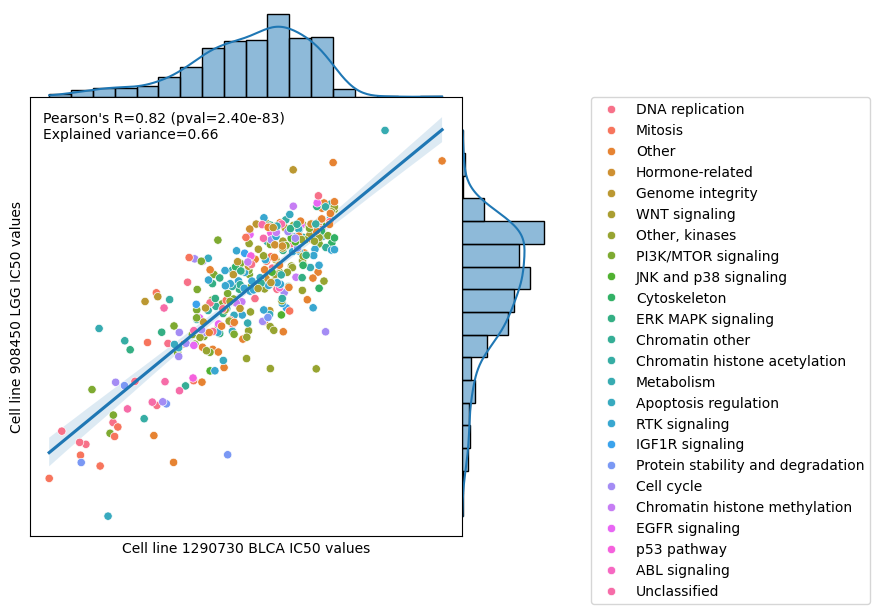

In [116]:
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr

np.random.seed(0)

def random_cell_line(cancer_type):
    cell_lines = gdsc_drug_response[gdsc_drug_response['TCGA Classification'] == cancer_type]['Cosmic ID'].values
    return np.random.choice(cell_lines)

cl_id1 = random_cell_line('BLCA')
cl_id2 = random_cell_line('LGG')

data = gdsc_IC50_df.loc[[cl_id1, cl_id2]].dropna(axis=1).T

expl_var = explained_variance_score(data.T.loc[cl_id1], data.T.loc[cl_id2])
pearson = pearsonr(data.T.loc[cl_id1], data.T.loc[cl_id2])

axs = sns.jointplot(data=data_drugs, x=cl_id1, y=cl_id2, kind='reg', height=6, space=0, scatter_kws={'s': 1})

sns.scatterplot(data=data_drugs, x=cl_id1, y=cl_id2, hue='pathway_name')

plt.legend(bbox_to_anchor=(1.3, 1), loc=2, borderaxespad=0.)
axs.ax_joint.set_xlabel('Cell line %d BLCA IC50 values' % (cl_id1))
axs.ax_joint.set_ylabel('Cell line %d LGG IC50 values' % (cl_id2))
axs.ax_joint.grid(False)

axs.ax_joint.set_xticks([])
axs.ax_joint.set_yticks([])

stats_vals = "Pearson's R=%.2f (pval=%.2e)\nExplained variance=%.2f" % (pearson[0], pearson[1], expl_var)

axs.ax_joint.annotate(stats_vals, xy=(0, 1), xycoords='axes fraction', 
                      xytext=(10, -10), textcoords='offset points',
                      ha='left', va='top', fontsize=10)
plt.savefig('figures/correlations/2_cell_lines.pdf', facecolor = 'white', 
            transparent = False, dpi=300, bbox_inches='tight') 

# Fig. 1 B

In [118]:
def plot_pearson_spearman(df, text, outfile, figsize = (4, 2)):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = figsize)

    sns.boxplot(x="Viability", y="Correlation", hue="Method", data=df, ax = axs, 
                showfliers = False)  
    
    axs.set_xlabel(None)
    axs.set_ylabel('Pairwise correlation')
    axs.set_title(text, fontsize='10')
    axs.set_xticklabels(axs.get_xticklabels())
    axs.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs.grid(False)
    axs.legend(bbox_to_anchor=(1, 1.05), title='Correlation', title_fontsize='10', fontsize='10')

    plt.savefig(outfile, facecolor = 'white', 
                transparent = False, dpi=300, bbox_inches='tight') 

/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_6633/2779185070.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels())


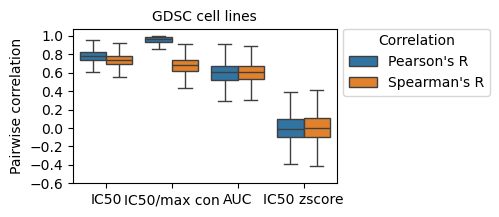

In [119]:
plot_pearson_spearman(gdsc_df, 'GDSC cell lines', 'figures/correlations/GDSC_correlations.pdf', figsize = (3.4, 2))

# Pancreatic AUC dataset

In [68]:
pan_viability_file = '/Users/katja/Projects/ProstateCancer/databases/Pancreatic/Table S4 Tiriac et al CD 2018.xlsx'
pan_viability_targeted_df = pd.read_excel(pan_viability_file, sheet_name = 'Targeted', skiprows = [0], index_col = 0).replace({'#N/A': np.nan})
pan_viability_chemo_df = pd.read_excel(pan_viability_file, sheet_name = 'Chemo', skiprows = [0], index_col = 0).replace({'#N/A': np.nan}).drop(columns = 'Insensitive')
pan_viability_df = pan_viability_targeted_df.join(pan_viability_chemo_df, how = 'outer')
pan_viability_df = pan_viability_df.dropna(how = 'all', axis = 1)
pan_viability_zscore_df = (pan_viability_df - pan_viability_df.mean()) / pan_viability_df.std()
pan_viability_df.head()

,Selumetinib,Afatinib,Bortezomib,Lapatinib,Sunitinib,Olaparib,Nutlin-3,MK-2206,KU-55933,Everolimus,...,LY2874455,SF1670,K-ras(G12C) Inhibitor 9,WIKI4,Disulfuram,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
Sample ID,,,,,,,,,,,,,,,,,,,,,
hF2,0.728,0.772,0.250,0.750,0.740,0.716,0.800,0.756,0.812,0.830,...,0.654,0.734,0.824,0.698,0.538,0.554358,0.712962,0.499950,0.782922,0.887246
hF23,0.692,0.548,0.232,0.762,0.814,0.856,0.928,0.752,0.876,0.728,...,0.630,0.776,0.850,0.838,0.516,0.523995,0.486711,0.547860,0.781999,0.820843
hF24,0.758,0.632,0.238,0.862,0.916,0.854,0.910,0.780,0.842,0.636,...,0.678,0.854,0.830,0.858,0.578,0.609942,0.742389,0.549167,0.671272,0.809528
hF27,0.816,0.828,0.274,0.816,0.780,0.854,0.872,0.798,0.786,0.764,...,0.722,0.696,0.818,0.798,0.572,0.677162,0.636766,0.567865,0.838669,0.852603
hF28,0.700,0.668,0.236,0.842,0.844,0.838,0.856,0.768,0.866,0.750,...,0.570,0.766,0.826,0.818,0.470,0.685010,0.662779,0.651442,0.861745,0.829213


In [69]:
pan_pears_corr_df = gen_corr_df(pan_viability_df, 'pearson', 'AUC')
pan_spear_corr_df = gen_corr_df(pan_viability_df, 'spearman', 'AUC')
pan_pears_zscore_corr_df = gen_corr_df(pan_viability_zscore_df, 'pearson', 'AUC zscore')
pan_spear_zscore_corr_df = gen_corr_df(pan_viability_zscore_df, 'spearman', 'AUC zscore')

pan_df = pd.concat([pan_pears_corr_df, pan_spear_corr_df, pan_pears_zscore_corr_df, pan_spear_zscore_corr_df])

/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_6633/2779185070.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels())


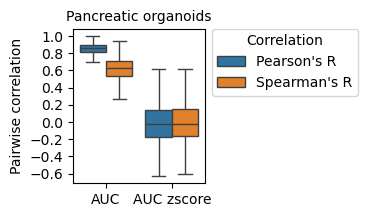

In [120]:
plot_pearson_spearman(pan_df, 'Pancreatic organoids', 'figures/correlations/Pancreatic_correlations.pdf', figsize = (1.7, 2))

# CCLE IC50 dataset

In [81]:
ccle_data = pd.read_csv('/Users/katja/Projects/ProstateCancer/databases/CCLE/drug screen/CCLE_NP24.2009_Drug_data_2015.02.24.csv')
ccle_data = ccle_data.rename(columns = {'IC50 (uM)': 'IC50'})
ccle_data['Max Conc'] = np.where(ccle_data['Doses (uM)'].astype(str).str.endswith('2.53'), 2.53, 8)
ccle_data['IC50/max con'] = ccle_data['IC50'] / ccle_data['Max Conc']
ccle_viability = ccle_data.pivot(index='Primary Cell Line Name', values = 'IC50', columns = 'Compound')
ccle_viability_zscore = (ccle_viability - ccle_viability.mean()) / ccle_viability.std()
ccle_viability.head()

Compound,17-AAG,AEW541,AZD0530,AZD6244,Erlotinib,Irinotecan,L-685458,LBW242,Lapatinib,Nilotinib,...,PHA-665752,PLX4720,Paclitaxel,Panobinostat,RAF265,Sorafenib,TAE684,TKI258,Topotecan,ZD-6474
Primary Cell Line Name,,,,,,,,,,,,,,,,,,,,,
1321N1,0.228078,8.000000,8.000000,8.0,8.000000,NaN,8.000000,8.0,8.000000,NaN,...,8.0,8.000000,0.002543,0.075148,8.000000,8.000000,3.001204,2.653239,0.148275,5.601102
22Rv1,0.329702,2.329924,8.000000,8.0,8.000000,0.080765,8.000000,8.0,7.847305,8.000000,...,8.0,8.000000,0.008228,0.027688,5.365867,6.819240,4.144046,5.879254,0.099059,8.000000
42-MG-BA,0.053038,2.682130,4.597950,8.0,8.000000,NaN,3.267752,8.0,8.000000,NaN,...,8.0,8.000000,0.002543,0.068958,NaN,8.000000,2.827591,0.229247,0.039294,8.000000
5637,0.070823,5.002314,3.192237,8.0,2.439512,0.067044,8.000000,8.0,2.307768,7.475355,...,8.0,3.738452,0.002920,0.048792,1.064666,7.166136,2.473094,5.962202,0.173502,3.398403
639-V,0.150094,1.736181,8.000000,8.0,8.000000,0.069569,8.000000,8.0,8.000000,8.000000,...,8.0,8.000000,0.002500,0.081506,2.779998,8.000000,2.217581,3.313957,0.043717,4.168948


In [91]:
ccle_pears_corr_df = gen_corr_df(ccle_viability, 'pearson', 'IC50')
ccle_spear_corr_df = gen_corr_df(ccle_viability, 'spearman', 'IC50')
ccle_pears_zscore_corr_df = gen_corr_df(ccle_viability_zscore, 'pearson', 'IC50 zscore')
ccle_spear_zscore_corr_df = gen_corr_df(ccle_viability_zscore, 'spearman', 'IC50 zscore')
#ccle_pears_mc_corr_df = gen_corr_df(pivot_column('IC50/max con', ccle_data), 'pearson', 'IC50/max con')
#ccle_spear_mc_corr_df = gen_corr_df(pivot_column('IC50/max con', ccle_data), 'spearman', 'IC50/max con')

ccle_df = pd.concat([ccle_pears_corr_df, ccle_spear_corr_df, 
                     #ccle_pears_mc_corr_df, ccle_spear_mc_corr_df,
                     ccle_pears_zscore_corr_df, ccle_spear_zscore_corr_df,
                    ])

/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_6633/2779185070.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels())


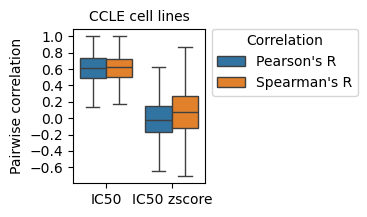

In [121]:
plot_pearson_spearman(ccle_df, 'CCLE cell lines', 'figures/correlations/CCLE_correlations.pdf', figsize = (1.7, 2))

# CTRP AUC dataset

In [111]:
ctrp_data = pd.read_csv('/Users/katja/Projects/ProstateCancer/databases/CTRP/auc.csv', index_col = 0)
# remove cell line/compound duplicates by taking average AUC
ctrp_data = ctrp_data.groupby(['master_cpd_id', 'master_ccl_id'], as_index=False)['area_under_curve'].mean()
ctrp_viability = ctrp_data.pivot(index='master_ccl_id', values = 'area_under_curve', columns = 'master_cpd_id')
ctrp_viability_zscore = (ctrp_viability - ctrp_viability.mean()) / ctrp_viability.std()
ctrp_viability.head()

master_cpd_id,1788,3588,12877,17712,18311,19153,23151,23256,24173,24197,...,688138,688229,688516,688799,688888,688962,688975,689506,705300,710154
master_ccl_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,11.128,12.328,12.305,13.085,10.025,13.405,13.164,11.376,14.525,...,14.792,5.1539,14.528,12.468,7.5696,13.434,9.4761,NaN,13.380,NaN
3,12.331,11.947,13.402,13.822,14.240,14.486,14.762,15.213,12.540,NaN,...,NaN,NaN,NaN,NaN,10.2180,NaN,NaN,NaN,13.281,NaN
4,14.982,12.110,14.529,14.997,13.911,14.702,12.093,14.929,13.683,NaN,...,NaN,NaN,NaN,NaN,10.8750,NaN,NaN,NaN,14.691,NaN
7,14.504,14.819,14.101,14.631,13.506,14.657,13.652,NaN,13.421,NaN,...,NaN,NaN,NaN,NaN,10.7870,NaN,NaN,NaN,13.193,NaN
8,14.557,NaN,14.546,13.969,12.379,13.258,13.697,16.630,13.985,NaN,...,NaN,NaN,NaN,NaN,12.4790,NaN,NaN,NaN,14.414,NaN


In [114]:
ctrp_pears_corr_df = gen_corr_df(ctrp_viability, 'pearson', 'AUC')
ctrp_spear_corr_df = gen_corr_df(ctrp_viability, 'spearman', 'AUC')
ctrp_pears_zscore_corr_df = gen_corr_df(ctrp_viability_zscore, 'pearson', 'AUC zscore')
ctrp_spear_zscore_corr_df = gen_corr_df(ctrp_viability_zscore, 'spearman', 'AUC zscore')

ctrp_df = pd.concat([ctrp_pears_corr_df, ctrp_spear_corr_df, 
                     ctrp_pears_zscore_corr_df, ctrp_spear_zscore_corr_df,
                    ])

/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_6633/2779185070.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels())


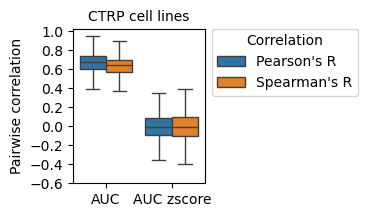

In [122]:
plot_pearson_spearman(ctrp_df, 'CTRP cell lines', 'figures/correlations/CTRP_correlations.pdf', figsize = (1.7, 2))

# Supplementary image, correlation of cell lines of the same cancer type

In [131]:
def group_correlation(group_name):
    ct_pears_corr_df = pd.DataFrame()
    ct_spear_corr_df = pd.DataFrame()
    for group_type, rows in gdsc_drug_response[~gdsc_drug_response[group_name].isin(['UNCLASSIFIED', 'ALL', 'Unclassified', '-', 'Other', np.nan])].groupby(group_name):
        cl_ids = rows['Cosmic ID'].unique()
        if len(cl_ids)<5: continue
        drug_ids = rows['Drug ID'].unique()
        if len(drug_ids)<5: continue
            
        loc_pears_corr_df = gen_corr_df(gdsc_IC50_df.loc[cl_ids][drug_ids], 'pearson', 'IC50')
        loc_pears_corr_df['Group type'] = [group_type] * len(loc_pears_corr_df)
        ct_pears_corr_df = pd.concat([ct_pears_corr_df, loc_pears_corr_df])
        
        loc_spear_corr_df = gen_corr_df(gdsc_IC50_df.loc[cl_ids][drug_ids], 'spearman', 'IC50')
        loc_spear_corr_df['Group type'] = [group_type] * len(loc_spear_corr_df)
        ct_spear_corr_df = pd.concat([ct_spear_corr_df, loc_spear_corr_df])
        
    ct_corr_df = pd.concat([ct_pears_corr_df, ct_spear_corr_df])
    return ct_corr_df

def plot_group_correlation(ct_corr_df, text, outfile, figsize = (10, 2)):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = figsize)

    sns.boxplot(x="Group type", y="Correlation", hue="Method", data=ct_corr_df, ax = axs, 
                showfliers = False) 
    
    axs.set_ylabel('Pairwise correlation')
    axs.set_xlabel(None)
    axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
    axs.grid(False)
    axs.set_title(text, fontsize='10')
    
    axs.legend(bbox_to_anchor=(1, 1.05), title='Correlation', title_fontsize='10', fontsize='10')

    plt.savefig(outfile, facecolor = 'white', 
                transparent = False, dpi=300, bbox_inches='tight') 

/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_6633/3715432328.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


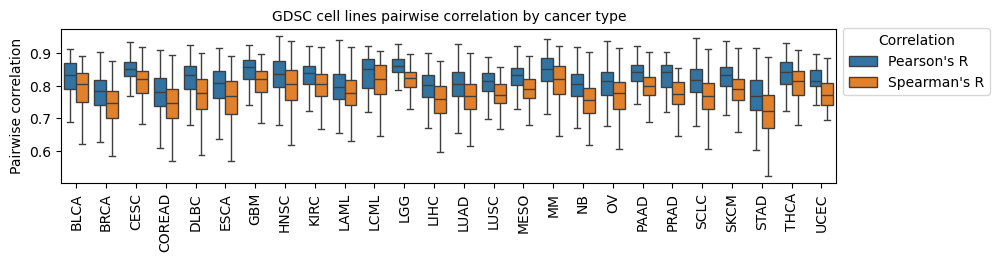

In [132]:
ct_corr_df = group_correlation('TCGA Classification')
plot_group_correlation(ct_corr_df, 'GDSC cell lines pairwise correlation by cancer type', 
                       'figures/correlations/GDSC_cancer_type_correlations.pdf')

/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_6633/3715432328.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


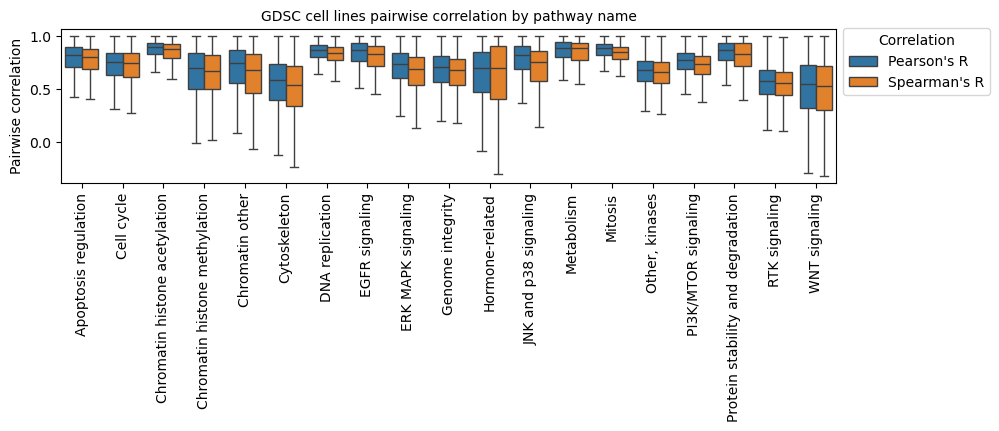

In [134]:
pw_corr_df = group_correlation('pathway_name')
plot_group_correlation(pw_corr_df, 'GDSC cell lines pairwise correlation by pathway name', 
                       'figures/correlations/GDSC_pathway_name_correlations.pdf')

<Axes: >

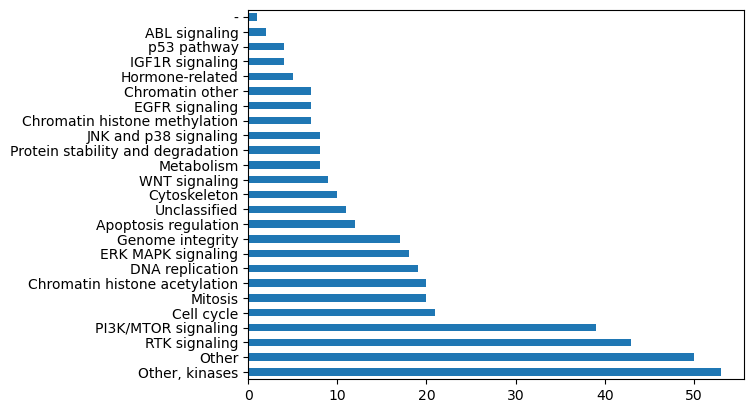

In [144]:
gdsc_drug_response[['pathway_name', 'Drug ID']].drop_duplicates()['pathway_name'].value_counts().plot(kind='barh', ylabel = '')